## Full likelihood

In this notebook we show some example syntax for the new 'full likelihood'. The `likelihood` object remains pretty much the same, but here we use a new `FullTheory` object that replaces `LyaTheory` which deals with the mapping from a set of likelihood parameters (`like_params=[..]`) to a set of emulator calls and a $P_{1\rm{D}}$ in velocity units. The `FullTheory` object works in Planck units, i.e. $\omega_b^2$, $\omega_c^2$, $A_s$, $n_s$ so far, we can add more later on. It uses `CAMB` to map these parameters directly into a set of emulator calls $\Delta^2_p$, $n_p$, etc at each $z$ where we have data.

NB that there is a bit of duplicate code in this iteration which can be tidied up eventually, in that the syntax I use to fit the emulator calls is also found in `fit_linP`, however there the comoving linear power is calculated at each $z$ independently, and I thought it might be faster to give all $z$s to `CAMB` to calculate at once. If it is faster this way, this will matter when it comes to sampling. The other point to note is that I do not currently calculate $f_p$, which is done in the `fit_linP` fits, and I do that as we have not yet trained the emulator on it so I do not yet want to slow down likelihood evaluations calculating an expensive quantitity that is not used.

Also to avoid calling `CAMB` twice in different parts of the code, `get_emulator_calls()` now also has an option `return_M_of_z` which will give $M(z)$ for each emulator call, which is then used to convert the comoving $P_{1\rm{D}}$ into velocity units.

First we set up a `data` object and an emulator as normal.

In [1]:
import camb_cosmo
import likelihood_parameter
import copy
import fit_linP
import camb
import full_theory
import data_MPGADGET
import p1d_arxiv
import gp_emulator
import likelihood

In [2]:
data=data_MPGADGET.P1D_MPGADGET()

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


In [3]:
test_sim_num=15
skewers_label='Ns500_wM0.05'
#skewers_label=None
#basedir="/p1d_emulator/sim_suites/emulator_256_28082019/"
basedir="/p1d_emulator/sim_suites/Australia20/"
p1d_label=None
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
like_params=["Delta2_star","n_star"]
like_param_limits=[[0.3,0.4],[-2.35,-2.2]]
max_arxiv_size=None
kmax_Mpc=8
z_list=None
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=test_sim_num,
                            drop_tau_rescalings=True,z_max=4,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [4]:
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=8,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 270 points
Optimised


In [5]:
## Here we create our new theory object
full_theory=full_theory.FullTheory(zs=data.z,emulator=emu)

Note: redshifts have been re-sorted (earliest first)


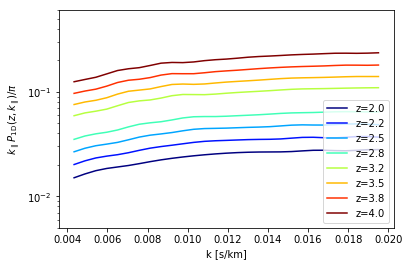

In [6]:
## Plot the fiducial P1D
full_theory.plot_p1d(data.k)

In [7]:
## Show that our emulator calls are changing when we change some likelihood parameters
like_param_list=full_theory.get_parameters()

In [8]:
like_param_list[0].value=0.019 ## Change ombh2 from 0.022 to 0.019
like_param_list[2].value=1.9e-9 ## Change As from 2.1 to 1.9 e-9
like_param_list[3].value=0.92 ## Change ns from 0.965 to 0.96

Note: redshifts have been re-sorted (earliest first)


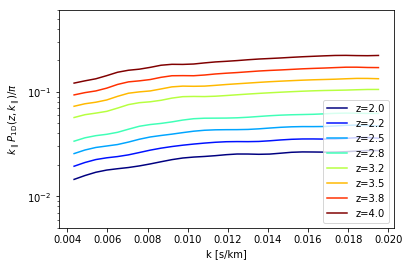

In [9]:
## Plot P1D for new set of parameters
## hard to see much difference here by eye but we can see it in the emulator calls
full_theory.plot_p1d(data.k,like_param_list)

In [10]:
emu_calls_fid=full_theory.get_emulator_calls(like_params=[],return_M_of_z=False)
emu_calls_modified=full_theory.get_emulator_calls(like_params=like_param_list,return_M_of_z=False)

print("z=2 emulator calls for fiducial = ", emu_calls_fid[0])
print("z=2 emulator calls after modifying = ", emu_calls_modified[0])

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
z=2 emulator calls for fiducial =  {'kF_Mpc': 9.234642271117814, 'sigT_Mpc': 0.13078611068417573, 'alpha_p': -0.21652698308263113, 'n_p': -2.299445461757138, 'Delta2_p': 0.6300510342450929, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829}
z=2 emulator calls after modifying =  {'kF_Mpc': 9.147325604109446, 'sigT_Mpc': 0.13203454194924402, 'alpha_p': -0.21744466797420398, 'n_p': -2.3437864627724245, 'Delta2_p': 0.5399184497092112, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829}


So we can see that the cosmology-related emulator parameters change in a way that appears to make sense, and it looks like things are working ok. Next step is to set up a likelihood object using this new `FullTheory`, and try get some `log_probs` as a function of changing Planck parameters

In [11]:
## Try setting up a likelihood object with the new theory object
free_params=["ombh2","omch2","As"]
full_like=likelihood.Likelihood(data=data,theory=full_theory,
                            free_parameters=free_params,
                            free_param_limits=None,
                            verbose=True,
                            prior_Gauss_rms=0.15,
                            emu_cov_factor=1)

likelihood setup with 3 free parameters
3 free parameters


In [12]:
full_like.log_prob(values=[0.52,0.55,0.45]) ## Evaluate a random log prob

Note: redshifts have been re-sorted (earliest first)
got P1D from emulator
compute chi2 for z=2.0
added 10.965341946862814 to log_like
compute chi2 for z=2.25
added 8.29329900624052 to log_like
compute chi2 for z=2.5
added 2.323559651010793 to log_like
compute chi2 for z=2.75
added -24.50693355435529 to log_like
compute chi2 for z=3.25
added -83.94798551387154 to log_like
compute chi2 for z=3.5
added -79.30662665853278 to log_like
compute chi2 for z=3.75
added -34.16196666598757 to log_like
compute chi2 for z=4.0
added -44.08264510601597 to log_like


-244.98840133909349